In [82]:
import scipy.special as spspec
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

# Task 2

In [83]:
dump = np.zeros((5001, 699, 5))
for timestep in trange(5001):
    dump[timestep, :, :] = np.genfromtxt(f'noefield.out/dump.unwrapped.{timestep}.txt', skip_header=9)

100%|██████████| 5001/5001 [00:28<00:00, 176.48it/s]


In [84]:
dump.shape

(5001, 699, 5)

In [85]:
coords = dump[:, :, -3:]
coords_O = coords[:, ::3, :]
coords_H1 = coords[:, 1::3, :]
coords_H2 = coords[:, 2::3, :]

In [86]:
coords_O.shape, coords_H1.shape, coords_H2.shape

((5001, 233, 3), (5001, 233, 3), (5001, 233, 3))

## 2a

In [87]:
u_ensemble = (coords_H1 + coords_H2) / 2 - coords_O
norm_u = np.linalg.norm(u_ensemble[0, 0, :])  # for other u the norm is the same
u_ensemble /= norm_u

In [88]:
u_ensemble.shape

(5001, 233, 3)

In [89]:
u_ensemble[0, 0, :]

array([-0.94751615, -0.31537794,  0.05243956])

In [90]:
u0_ensemble = u_ensemble[0, :, :]

K_u = (u0_ensemble * u_ensemble).sum(axis=2).mean(axis=1)
# K_u = []
# for timestep in trange(5001):
#     res = 0.
#     for atom in range(699):
#         res += u0[atom] @ coords[timestep, atom, :]
#     K_u.append(res / 699)

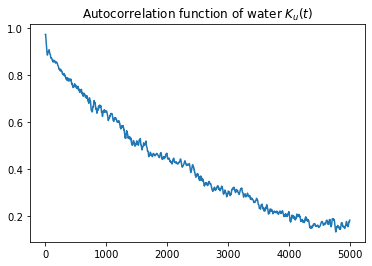

In [91]:
plt.plot(K_u)
plt.title('Autocorrelation function of water $K_u(t)$');

In [92]:
def Y(u, m, l):
    r = np.linalg.norm(u, axis=2)
    theta = np.arccos(u[:, :, 2] / r)
    phi = np.arctan2(u[:, :, 1], u[:, :, 0])
    return spspec.sph_harm(m, l, theta, phi)

In [93]:
def Y_conj(u, m, l):
    return (-1)**m * Y(u, m, l)

In [94]:
def P(u1, u2, l):
    return 4 * np.pi / (2 * l + 1) * sum(Y_conj(u1, m, l) * Y(u2, m, l) for m in range(-l, l + 1))

In [95]:
def Psi(u_ensemble, l):
    u0_ensemble = u_ensemble[0, :, :] * np.ones(u_ensemble.shape)
    return P(u0_ensemble, u_ensemble, l).mean(axis=1)
    
#     res = []
#     for t in trange(u_ensemble.shape[0]):
#         P_l = 0.
#         for atom in range(u_ensemble.shape[1]):
#             P_l += P(u0_ensemble[atom, :], u_ensemble[t, atom, :], l)
#         P_l /= u_ensemble.shape[1]
#         res.append(P_l)
#    return np.array(res)

In [96]:
psi2 = Psi(u_ensemble, 2)

In [97]:
psi3 = Psi(u_ensemble, 3)

C:\Users\kuzne\anaconda3\envs\scientific\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


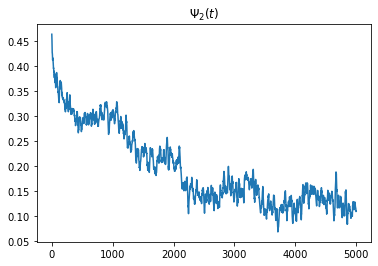

In [98]:
plt.plot(psi2)
plt.title('$\Psi_{2}(t)$');

C:\Users\kuzne\anaconda3\envs\scientific\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


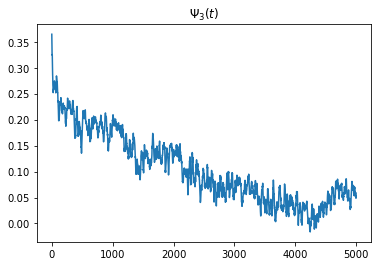

In [99]:
plt.plot(psi3)
plt.title('$\Psi_{3}(t)$');

In [100]:
thermo = np.genfromtxt('noefield.out/thermo.txt', skip_header=1)
steps = thermo[:, 0]
T = thermo[:, 1]
p = thermo[:, 2]
L = thermo[:, 3]
rho = thermo[:, 4]

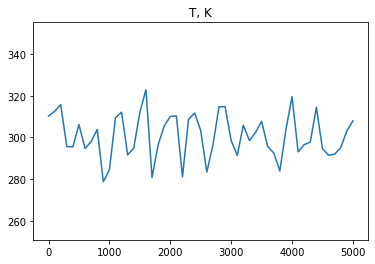

In [101]:
plt.plot(steps, T)
plt.ylim(.9 * min(T), 1.1 * max(T))
plt.title('T, K');

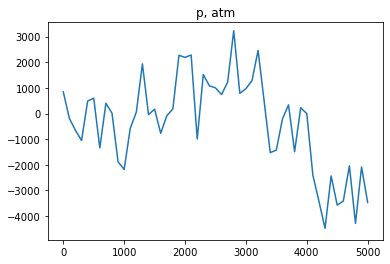

In [102]:
plt.plot(steps, p)
plt.ylim(min(p) - .1 * abs(min(p)), 1.1 * max(p))
plt.title('p, atm');

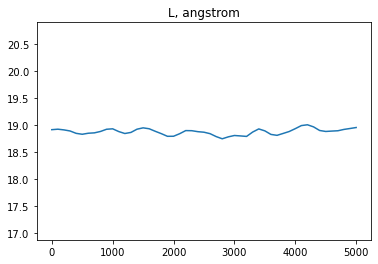

In [103]:
plt.plot(steps, L)
plt.ylim(.9 * min(L), 1.1 * max(L))
plt.title('L, angstrom');

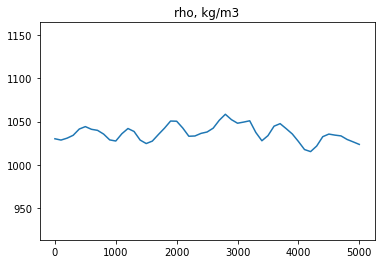

In [104]:
plt.plot(steps, rho)
plt.ylim(.9 * min(rho), 1.1 * max(rho))
plt.title('rho, kg/m3');

## 2b

In [110]:
dt = 1.
tau_u = K_u.sum() * dt
tau_2 = psi2.sum() * dt
tau_3 = psi3.sum() * dt
# Imaginary part is negligibly small and corresponds to numerical round-off.
tau_u, tau_2.real, tau_3.real

(2086.636814700636, 971.2021859802524, 523.8429115327469)

## 2c

In [112]:
dump_e = np.zeros((5001, 699, 5))
for timestep in trange(5001):
    dump_e[timestep, :, :] = np.genfromtxt(f'efield.out/dump.unwrapped.{timestep}.txt', skip_header=9)

100%|██████████| 5001/5001 [00:27<00:00, 178.96it/s]


In [113]:
u_e_ensemble = dump_e[:, :, -3:]
u_e_ensemble.shape

(5001, 699, 3)

In [114]:
coords = dump_e[:, :, -3:]
coords_O = coords[:, ::3, :]
coords_H1 = coords[:, 1::3, :]
coords_H2 = coords[:, 2::3, :]

u_ensemble = (coords_H1 + coords_H2) / 2 - coords_O
norm_u = np.linalg.norm(u_ensemble[0, 0, :])  # for other u the norm is the same
u_ensemble /= norm_u

u0_ensemble = u_ensemble[0, :, :]

K_u_e = (u0_ensemble * u_ensemble).sum(axis=2).mean(axis=1)

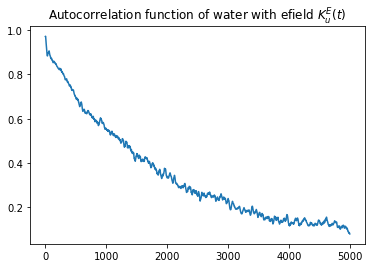

In [115]:
plt.plot(K_u_e)
plt.title('Autocorrelation function of water with efield $K_u^E(t)$');

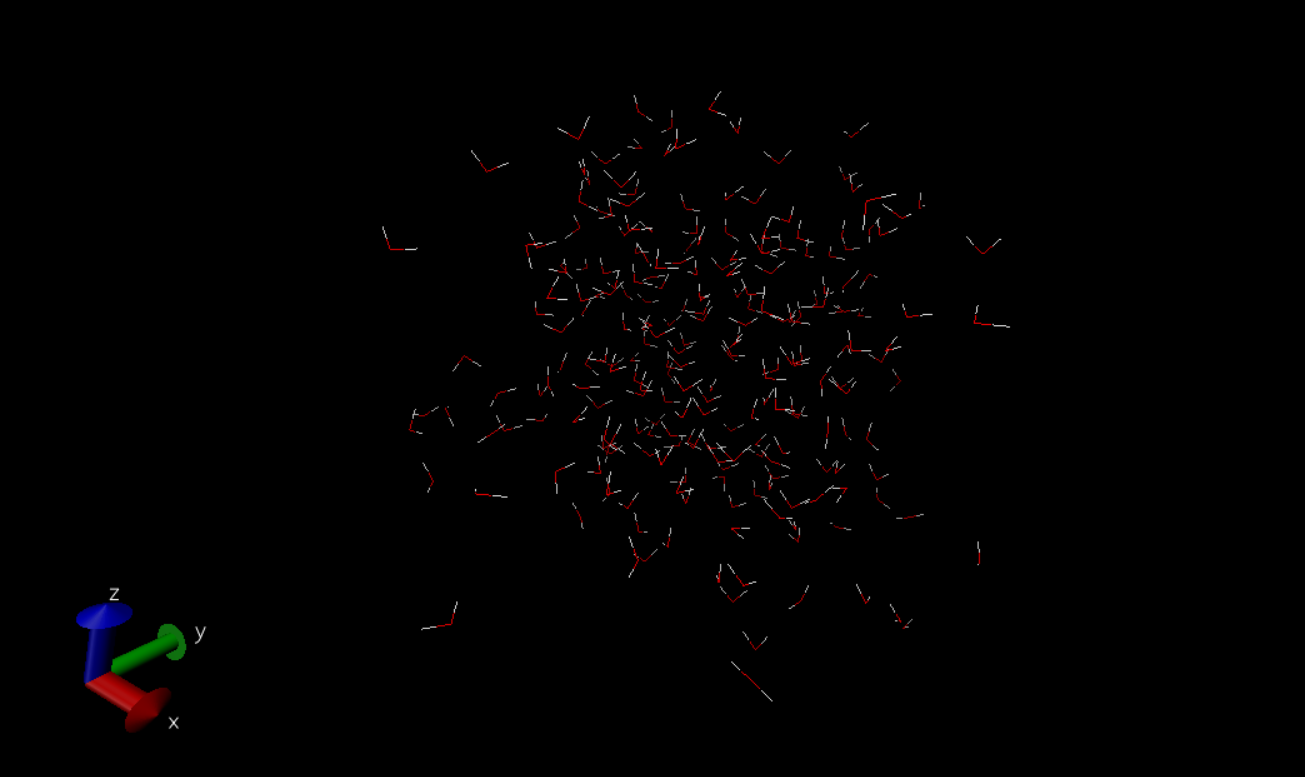

We see that the majority of the molecules are oriented against Z axis. This result is expected.

# Task 3

## 3a

In [122]:
MSD_data = np.genfromtxt('noefield.out/MSD.txt')

In [125]:
timedata = MSD_data[:, 0]
MSD = MSD_data[:, 1] / 6 / timestep
D = 1 / 6 / timedata * MSD

C:\Users\kuzne\AppData\Local\Temp/ipykernel_18168/1433040544.py:3: RuntimeWarning: divide by zero encountered in true_divide
  D = 1 / 6 / timedata * MSD


Text(0.5, 1.0, 'D')

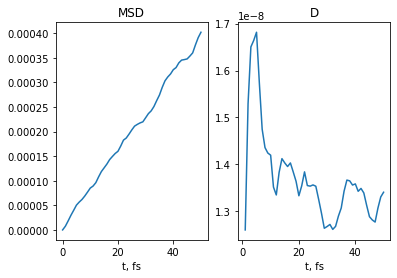

In [126]:
plt.subplot(1, 2, 1)
plt.plot(MSD)
plt.xlabel('t, fs')
plt.title('MSD')
plt.subplot(1, 2, 2)
plt.plot(D)
plt.xlabel('t, fs')
plt.title('D')

In [129]:
D[1:].mean()

1.370813633843686e-08

## 3b

In [130]:
data = np.genfromtxt('noefield.out/RDF.txt', skip_header=4)
r = data[:, 1]
rdf_oo = data[:, 2]
rdf_oh = data[:, 4]

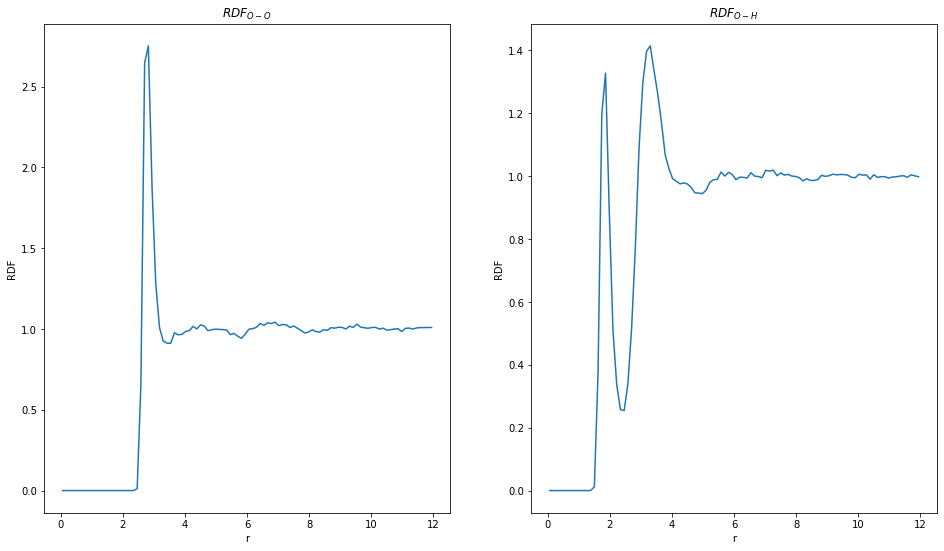

In [135]:
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))

ax[0].plot(r, rdf_oo)
ax[0].set_xlabel('r')
ax[0].set_ylabel('RDF')
ax[0].set_title('$RDF_{O-O}$')

ax[1].plot(r, rdf_oh)
ax[1].set_xlabel('r')
ax[1].set_ylabel('RDF')
ax[1].set_title('$RDF_{O-H}$');

In [136]:
# According to the graphs:
d_oo = 3
d_oh = 2

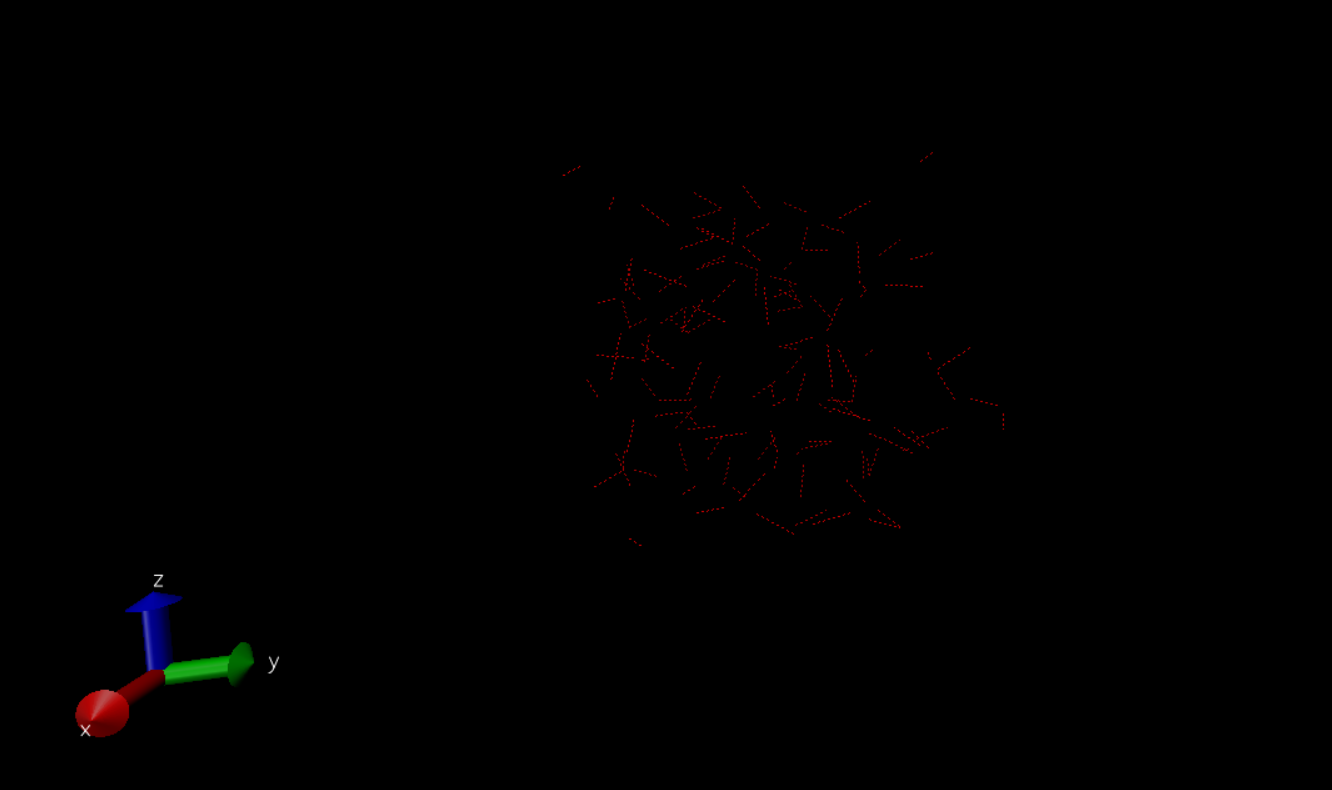